In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import urllib.request as ur
import json
import datetime
%matplotlib inline

In [5]:
# load oroginal dataset from kaggle
df = pd.read_csv('Data/cdc_zika.csv', low_memory=False) 

In [7]:
df.head()

,report_date,location,location_type,data_field,data_field_code,time_period,time_period_type,value,unit
0,2016-03-19,Argentina-Buenos_Aires,province,cumulative_confirmed_local_cases,AR0001,NaN,NaN,0,cases
1,2016-03-19,Argentina-Buenos_Aires,province,cumulative_probable_local_cases,AR0002,NaN,NaN,0,cases
2,2016-03-19,Argentina-Buenos_Aires,province,cumulative_confirmed_imported_cases,AR0003,NaN,NaN,2,cases
3,2016-03-19,Argentina-Buenos_Aires,province,cumulative_probable_imported_cases,AR0004,NaN,NaN,1,cases
4,2016-03-19,Argentina-Buenos_Aires,province,cumulative_cases_under_study,AR0005,NaN,NaN,127,cases


In [8]:
# take only rows where location and value is not null
df = df[df['location'].notnull()]
df = df[df['value'].notnull()]

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 107481 entries, 0 to 107618
Data columns (total 9 columns):
report_date         107481 non-null object
location            107481 non-null object
location_type       107481 non-null object
data_field          107481 non-null object
data_field_code     107481 non-null object
time_period         0 non-null float64
time_period_type    0 non-null float64
value               107481 non-null object
unit                107481 non-null object
dtypes: float64(2), object(7)
memory usage: 8.2+ MB


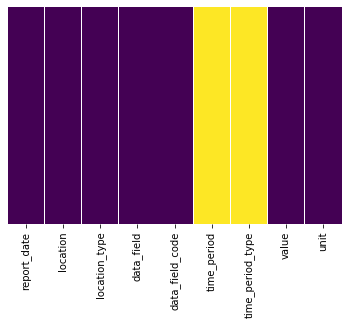

In [10]:
# check missing data
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [11]:
# drop columns 'time_period','time_period_type','unit' ; they do not have info
df = df.drop(['time_period','time_period_type','unit'],axis=1)  


In [12]:
# create country column based on location
df['country'] = df['location']
df['country'] = df['country'].astype(str)
df['country'] = df['country'].apply(lambda x: pd.Series(x.split('-')))


In [13]:
# fix country data
def fix_country(val):
    if val == 'Nordeste' or val=='Norte' or val == 'Sudeste' or val == 'Sul' or val == 'Centro':
        return 'Brazil'
    elif val == 'United_States_Virgin_Islands':
        return 'United States Virgin Islands'
    else:
        return val
    
df['country'] = df['country'].apply(fix_country)

In [14]:
df.country.unique()

array(['Argentina', 'Brazil', 'Colombia', 'Dominican_Republic', 'Ecuador',
       'El_Salvador', 'Guatemala', 'Haiti', 'Mexico', 'Nicaragua',
       'Panama', 'Puerto_Rico', 'United_States',
       'United States Virgin Islands'], dtype=object)

In [15]:
# fix country names, remove underscore
def fix_country(country):
    return str(country).replace("_"," ")

df['country'] = df['country'].apply(fix_country)

In [16]:
df.head()

,report_date,location,location_type,data_field,data_field_code,value,country
0,2016-03-19,Argentina-Buenos_Aires,province,cumulative_confirmed_local_cases,AR0001,0,Argentina
1,2016-03-19,Argentina-Buenos_Aires,province,cumulative_probable_local_cases,AR0002,0,Argentina
2,2016-03-19,Argentina-Buenos_Aires,province,cumulative_confirmed_imported_cases,AR0003,2,Argentina
3,2016-03-19,Argentina-Buenos_Aires,province,cumulative_probable_imported_cases,AR0004,1,Argentina
4,2016-03-19,Argentina-Buenos_Aires,province,cumulative_cases_under_study,AR0005,127,Argentina


In [15]:
#df["data_field"].nunique()

In [16]:
#df["data_field_code"].nunique()

In [17]:
# fix report data, make it as date type
def fix_date(date):
    return str(date).replace("_","-")

df['report_date'] = df['report_date'].apply(fix_date)

In [18]:
df['report_date'] = pd.to_datetime(df['report_date'])

In [19]:
#df['year'] = pd.DatetimeIndex(df['report_date']).year

In [20]:
#df['month'] = pd.DatetimeIndex(df['report_date']).month

In [21]:
#df = df.drop(['report_date','location'],axis=1)  

In [20]:
# fix value column
for x in df['value'].iteritems():
    try:
        float(x[1])
    except:
        print(x)

(2414, '125*5')
(2783, '149*5')
(5192, '5*')


In [21]:
df.loc[2414, 'value'] = 0
df.loc[2783, 'value'] = 0
df.loc[5192, 'value'] = 0
df['value'] = df["value"].fillna(0)
df['value'] = df["value"].astype(int)

In [22]:
df["location_type"].unique()

array(['province', 'state', 'region', 'municipality', 'country', 'county',
       'department', 'Department', 'district', 'city', 'territory'],
      dtype=object)

In [23]:
df.head()

,report_date,location,location_type,data_field,data_field_code,value,country
0,2016-03-19,Argentina-Buenos_Aires,province,cumulative_confirmed_local_cases,AR0001,0,Argentina
1,2016-03-19,Argentina-Buenos_Aires,province,cumulative_probable_local_cases,AR0002,0,Argentina
2,2016-03-19,Argentina-Buenos_Aires,province,cumulative_confirmed_imported_cases,AR0003,2,Argentina
3,2016-03-19,Argentina-Buenos_Aires,province,cumulative_probable_imported_cases,AR0004,1,Argentina
4,2016-03-19,Argentina-Buenos_Aires,province,cumulative_cases_under_study,AR0005,127,Argentina


In [24]:
# groupby/summarize all occurences per location and date
df = df.groupby(['location','report_date', 'location_type', 'country'], as_index=False)['value'].sum()

In [25]:
# fix location type
def map_locations(x):
    location_mapper = {'state':'province',
                       'municipality':'city',
                       'department':'province',
                       'Region':'province',
                       'Collectivity':'province',
                       'territory':'province',
                       'district':'city'
                      }
    if x in location_mapper.keys():
        return location_mapper[x]
    else:
        return x
    
df['location_type'] = df['location_type'].apply(lambda x: map_locations(x))

In [26]:
# create new columns
df[['country', 'province', 'county', 'city']] = df.location.str.split(r"""-""", expand=True)

In [27]:
# remove underscore
for col in ['country', 'province', 'county', 'city']:
    df[col] = df[col].str.replace('_', ' ')

In [28]:
df.head()

,location,report_date,location_type,country,value,province,county,city
0,Argentina-Buenos_Aires,2016-03-19,province,Argentina,130,Buenos Aires,None,None
1,Argentina-Buenos_Aires,2016-03-26,province,Argentina,148,Buenos Aires,None,None
2,Argentina-Buenos_Aires,2016-04-02,province,Argentina,190,Buenos Aires,None,None
3,Argentina-Buenos_Aires,2016-04-09,province,Argentina,199,Buenos Aires,None,None
4,Argentina-Buenos_Aires,2016-04-16,province,Argentina,207,Buenos Aires,None,None


In [29]:
# fix for United_States-US_Virgin_Islands
def fix_virgin_islands(x):
    return str(x).replace("US Virgin Islands","Virgin Islands")

df['province'] = df['province'].apply(fix_virgin_islands)
#df[df["location"] == 'United_States-US_Virgin_Islands']

In [30]:
# fix Miami Dade county
def fix_florida_dade_county(x):
    return str(x).replace("Miami","Dade County")

def fix_florida_miami_city(x):
    return str(x).replace("Dade County","Miami")

df['county'] = df['county'].apply(fix_florida_dade_county)
df['city'] = df['city'].apply(fix_florida_miami_city)
#df[df["location"] == 'United_States-Florida-Miami-Dade_County']

In [31]:
# Fix for Santiago Del Estero Argentina
df.loc[df.location=='Argentina-Sgo_Del_Estero', 'province'] = 'Santiago Del Estero'
df.loc[df.location=='Argentina-CABA', 'province'] = 'Ciudad de Buenos Aires'

In [34]:
df.head()

,location,report_date,location_type,country,value,province,county,city
0,Argentina-Buenos_Aires,2016-03-19,province,Argentina,130,Buenos Aires,None,None
1,Argentina-Buenos_Aires,2016-03-26,province,Argentina,148,Buenos Aires,None,None
2,Argentina-Buenos_Aires,2016-04-02,province,Argentina,190,Buenos Aires,None,None
3,Argentina-Buenos_Aires,2016-04-09,province,Argentina,199,Buenos Aires,None,None
4,Argentina-Buenos_Aires,2016-04-16,province,Argentina,207,Buenos Aires,None,None


In [35]:
# save csv file for future needs
df.to_csv('zika_cleaned_data.csv', encoding='utf-8', index=False)